In [6]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize            #out = resize(dtest,(5,6), order=0, preserve_range=True)
from scipy.ndimage.morphology import distance_transform_edt, binary_fill_holes
from skimage.morphology import skeletonize, skeletonize_3d, remove_small_objects

# For lung segmentation
from lungmask import mask
import SimpleITK as sitk
import cv2

In [7]:
# https://skeleton-analysis.org/stable/getting_started/getting_started.html
# https://github.com/fsc-mib/travel
# https://github.com/RUB-Bioinf/VesselExpress

In [55]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize            #out = resize(dtest,(5,6), order=0, preserve_range=True)
from scipy.ndimage.morphology import distance_transform_edt, binary_fill_holes
from skimage.morphology import skeletonize, skeletonize_3d, remove_small_objects

# For lung segmentation
from lungmask import mask
import SimpleITK as sitk

class ExtractVesselFeatures:
    def __init__(self, path_ct, path_tumor_seg, path_vessel_seg, path_lung_seg=None, show_check=False, resize_111=True):
        self.min_v, self.max_v = -1000, 100
        # paths
        self.path_ct = path_ct
        self.path_tumor_seg = path_tumor_seg
        self.path_vessel_seg = path_vessel_seg
        # Loading ct, tumor and vessel segmentation
        self.ct = nib.load(self.path_ct)                 ; self.ct_array = np.rot90(self.ct.get_fdata(), k=-1, axes=(0, 1))       ; self.ct_affine =self.ct.affine
        tumor = nib.load(self.path_tumor_seg)       ; self.tumor_array = np.rot90(tumor.get_fdata(), k=-1, axes=(0, 1)) ; self.tumor_affine = tumor.affine
        vessel_seg = nib.load(self.path_vessel_seg) ; self.vessel_seg_array = vessel_seg.get_fdata()                    ; self.vessel_seg_affine = vessel_seg.affine        
        assert self.ct_array.shape==self.tumor_array.shape, "ct and tumor have diff shapes"
        assert self.ct_array.shape==self.vessel_seg_array.shape, "ct and vessel have diff shapes"
        # Obtain lung & vessels_only & dimension
        self.lung_array = self.obtain_lung_seg() if path_lung_seg == None else np.rot90(nib.load(path_lung_seg).get_fdata(), k=-1, axes=(0, 1))
        self.vessel_array = self.obtain_vessel()
        self.dimension_old = np.diag(np.abs(self.ct_affine))[0:3]
        
        if resize_111:
            print('Resizing to 111 spacing', )
            self.ct_array     = self.resize_1mm(self.ct_array)   
            self.lung_array   = self.resize_1mm(self.lung_array)
            self.tumor_array  = self.resize_1mm(self.tumor_array)
            self.vessel_array = self.resize_1mm(self.vessel_array)
            self.dimension = [1,1,1]
        
        self.tumor_core, self.tumor_inner, self.tumor_outer, self.chl_tumor = self.calculate_core_inner_outer()
        if show_check:
            self.show_check()
            self.show_check_tumor(self.chl_tumor)
        
    def resize_1mm(self, array_3d): 
        array_3d = array_3d.astype(np.float32)
        phy = array_3d.shape*self.dimension_old    # physical size
        iso = 1 # isotropic voxel
        new_size = np.round(phy/iso)   # new resampling size after interpolation 
        array_3d_interp = resize(array_3d, (new_size[0],new_size[1],new_size[2]), order=0, preserve_range=True)
        pixel_dim = np.round(phy/new_size)
        return array_3d_interp
        
    def calculate_core_inner_outer(self, outer_dist=10, img_resolution=1):
        # dilate and erode the mask
        tumor_core = np.empty(self.tumor_array.shape)
        tumor_inner = np.empty(self.tumor_array.shape)
        tumor_outer = np.empty(self.tumor_array.shape)
        
        outer_num = np.round(outer_dist/img_resolution)
        # loop through the nonzero slices
        sum_vec = self.tumor_array.sum(0).sum(0)   # 1D, gives the number of non-zero pixels in each slide, [ 0,   0,   0, 141, 190, 228, 0, 0]
        sele_idx = np.nonzero(sum_vec)             # array([3, 4, 5])
        for k in sele_idx[0]:
            tumor_2D = self.tumor_array[:,:,k] * 1
            tumor_2D = tumor_2D.astype(np.uint8)
            mask_dist = distance_transform_edt(tumor_2D)  #(512, 512)  #computes the distance from non-zero (i.e. non-background) points to the nearest zero (i.e. background) point.
            max_dist = np.amax(mask_dist)
            mask_erode = mask_dist > (max_dist/2)   # they are far from background in the tumor #https://stackoverflow.com/questions/44770396/how-does-the-scipy-distance-transform-edt-function-work
            mask_erode = mask_erode * 1
            tumor_core[:, :, k] = mask_erode
            tumor_inner[:, :, k] = tumor_2D - mask_erode
            mask_dist2 = distance_transform_edt(1-tumor_2D)
            mask_dilate = mask_dist2 <= outer_num
            mask_dilate = mask_dilate * 1
            tumor_outer[:, :, k] = mask_dilate

        tumor_outer = tumor_outer - self.tumor_array
        lung_tumor = np.logical_or(self.tumor_array, self.lung_array)
        self.tumor_outer = np.logical_and(lung_tumor, tumor_outer)
        chl = sele_idx[0][sele_idx[0].shape[0]//2]
        return tumor_core, tumor_inner, tumor_outer, chl
    
    def skeletonize_vessel(self, img, method='lee'):
        if method=='lee':
            skeleton = skeletonize(img, method='lee')
        else:
            skeleton = skeletonize(img)
        return skeleton
    
    def obtain_lung_seg(self):
        print('Obtaining lung segmentation...')
        #from lungmask import mask
        #import SimpleITK as sitk
        input_image = sitk.ReadImage(self.path_ct)
        segmentation = mask.apply(input_image)
        segmentation[segmentation!=0] = 1
        segmentation = np.transpose(segmentation,[1,2,0])
        for i in range(segmentation.shape[2]):
            segmentation[:,:,i] = np.fliplr(segmentation[:,:,i])
        return segmentation
    
    def show_check(self):
        fig = plt.figure(figsize= (16,4))
        fig.add_subplot(1,4,1)
        chl = self.ct_array.shape[2]//2 - 10
        plt.imshow(self.ct_array[:,:,chl],cmap='gray', vmin=-1000, vmax=200)
        fig.add_subplot(1,4,2)
        plt.imshow(self.lung_array[:,:,chl],cmap='gray', vmin=0, vmax=1)
        fig.add_subplot(1,4,3)
        plt.imshow(self.tumor_array[:,:,chl],cmap='gray', vmin=0, vmax=1)
        fig.add_subplot(1,4,4)
        plt.imshow(self.vessel_array[:,:,chl],cmap='gray', vmin=-1000, vmax=200)
        plt.show()
        
    def show_check_tumor(self, chl):
        fig = plt.figure(figsize= (12,4))
        fig.add_subplot(1,3,1)
        plt.imshow(self.tumor_core[:,:,chl],cmap='gray', vmin=0, vmax=1)
        fig.add_subplot(1,3,2)
        plt.imshow(self.tumor_inner[:,:,chl],cmap='gray', vmin=0, vmax=1)
        fig.add_subplot(1,3,3)
        plt.imshow(self.tumor_outer[:,:,chl],cmap='gray', vmin=0, vmax=1)
        plt.show()
        
    def obtain_vessel(self):
        min_v, max_v = self.min_v, self.max_v
        vessel_array = np.clip(self.ct_array, min_v, max_v)
        vessel_array = (vessel_array-min_v)/(max_v-min_v)
        vessel_array =  np.multiply(vessel_array, self.vessel_seg_array)
        vessel_array =  np.multiply(vessel_array, self.lung_array)
        vessel_array = vessel_array*(max_v-min_v) + min_v
        return vessel_array
        
    def normalize_01(self):
        pass
    
    def histogram_11(self, bins=11):
        vessel_pixels = self.vessel_array[self.tumor_outer == 1].reshape(-1)
        frq1, edges1 = np.histogram(vessel_pixels, bins=bins, range=(self.min_v, self.max_v))
        # normalize to pdf
        frq1 = frq1 / (np.sum(frq1) + 1e-10)
        return frq1

    def saving_outer_tumor_and_vessel(self, save_folder='./outer_tumor_and_vessel'):
        #Let's have both with the same ct.affine here
        os.makedirs(save_folder, exist_ok=True)
        vessel_NIFTI = nib.Nifti1Image(self.vessel_array, self.ct.affine)
        vessel_NIFTI.to_filename(os.path.join(save_folder, os.path.basename(path_ct[:-7])+'_vessel.nii.gz'))
        outer_NIFTI = nib.Nifti1Image(self.tumor_outer, self.ct.affine)
        outer_NIFTI.to_filename(os.path.join(save_folder, os.path.basename(path_ct[:-7])+'_tumor_outer_seg.nii.gz'))
         
        
    def radiomic_features(self, path_vesel, path_tumor_outer_seg ):
        self.saving_outer_tumor_and_vessel()
        from radiomics import featureextractor
        imagePath = os.path.join(path_vesel)#?????????????????????
        labelPath = os.path.join(path_tumor_outer_seg)#?????????????????????
        extractor = featureextractor.RadiomicsFeaturesExtractor(binWidth=100,  sigma=[1, 2, 3], verbose=True)
        extractor.disableAllFeatures()
        extractor.enableFeatureClassByName('firstorder')
        result = extractor.execute(imagePath, labelPath)
        return result

In [56]:
path_v = 'C:/Users/MSalehjahromi/ZipingRongqin/tumor vasculature/out_save/0001_414826_170323_v.nii.gz'      # 0001_414826_170323_v.nii.gz
path_ct = 'C:/Users/MSalehjahromi/ZipingRongqin/tumor vasculature/nifti_files/0001_414826_170323.nii.gz'  # 0001_414826_170323.nii.gz
path_t = 'C:/Users/MSalehjahromi/ZipingRongqin/tumor vasculature/nifti_files/0001_414826_170323_RTS_L1.nii.gz'   # 0001_414826_170323_RTS_L1.nii.gz

Obtaining lung segmentation...


100%|██████████| 59/59 [00:01<00:00, 51.95it/s] 


Resizing to 111 spacing


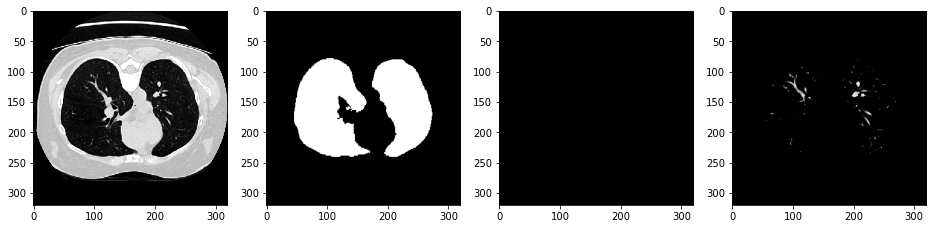

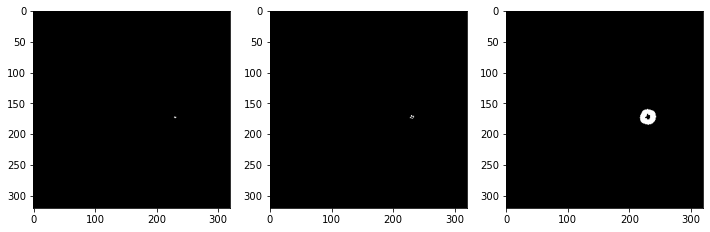

In [57]:
case1 = ExtractVesselFeatures(path_ct,path_t,path_v, show_check=True)
#core, inner, outer, _ = case1.calculate_core_inner_outer(outer_dist=10)

In [58]:
case1.saving_outer_tumor_and_vessel()

In [63]:
path_saved = './outer_tumor_and_vessel'
for case in os.listdir(path_saved):
    if case.endswith('vessel.nii.gz'):
        path_vesel = os.path.join(path_saved, case)
        path_tumor_outer_seg = os.path.join(path_saved, case[:-14]+'_tumor_outer_seg.nii.gz')
        
        case1.radiomic_features(path_vesel, path_tumor_outer_seg )

ModuleNotFoundError: No module named 'radiomics'

In [62]:
path_vesel

NameError: name 'path_vesel' is not defined

In [37]:
def resize_1mm_test(array_3d, dimension_old): 
    array_3d = array_3d.astype(np.float32)
    phy = array_3d.shape*dimension_old    # physical size
    iso = 1 # isotropic voxel
    new_size = np.round(phy/iso)   # new resampling size after interpolation 
    array_3d_interp = resize(array_3d, (new_size[0],new_size[1],new_size[2]), order=0, preserve_range=True)
    pixel_dim = np.round(phy/new_size)
    return array_3d_interp

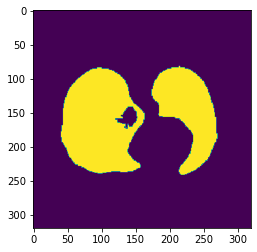

In [39]:
cc = resize_1mm_test(case1.lu, np.diag(np.abs(case1.ct_affine))[0:3])
plt.imshow(cc[:,:,100])

In [16]:
case1.lung_array.shape

(320, 320, 348)

In [ ]:
from lungmask import mask
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
#INPUT = nib.load(path_ct)
input_image = sitk.ReadImage(path_ct)
segmentation = mask.apply(input_image)  # default model is U-net(R231)

In [ ]:
plt.imshow(segmentation[59,:,:])

In [ ]:
model = mask.get_model('unet','LTRCLobes')
segmentation_m = mask.apply(input_image, model)

segmentation_f = mask.apply_fused(input_image)

In [ ]:
plt.imshow(segmentation_m[59,:,:])

In [ ]:
plt.imshow(segmentation_f[59,:,:])

In [1]:
from radiomics

SyntaxError: invalid syntax (tmp/ipykernel_23468/757730227.py, line 1)

In [2]:
import os  # needed navigate the system to get the input data

from radiomics import featureextractor

ModuleNotFoundError: No module named 'radiomics'

In [ ]:
from radiomics import featureextractor
imagePath = os.path.join(dataDir, testCase + "_image.nrrd")
labelPath = os.path.join(dataDir, testCase + "_label.nrrd")

# This cell is equivalent to the previous cell
extractor = featureextractor.RadiomicsFeaturesExtractor(binWidth=100,  sigma=[1, 2, 3], verbose=True)  # Equivalent of code above
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')

result = extractor.execute(imagePath, labelPath)

In [5]:
print(path_v)
os.path.basename(path_v)

C:/Users/MSalehjahromi/ZipingRongqin/tumor vasculature/out_save/0001_414826_170323_v.nii.gz


'0001_414826_170323_v.nii.gz'